In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Lambda
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import DBSCAN

In [2]:
def resize_wafer_map(wm, target_size=(64, 64)):
    return tf.image.resize(np.expand_dims(wm, axis=-1), target_size, method='nearest').numpy()

In [3]:
def one_hot_img(wm):
    h, w = wm.shape[0], wm.shape[1]
    one_hot = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            one_hot[i, j, int(wm[i, j])] = 1
    return one_hot

In [4]:
def add_noise(wm):
    h, w = wm.shape[0], wm.shape[1]
    n_change = int(0.01 * h * w)
    changed = 0
    noised = wm.copy()
    while changed < n_change:
        i, j = np.random.randint(0, h), np.random.randint(0, w)
        if wm[i, j, 0] == 0:  # If the point is on the wafer
            noised[i, j, 1] = int(not noised[i, j, 1])
            noised[i, j, 2] = int(not noised[i, j, 2])
            changed += 1
    return noised

In [5]:
def load_df(mapping):
    df = pd.read_pickle("data/LSWMD.pkl")
    df = df.drop(['trianTestLabel'], axis=1)
    df = df.drop(['waferIndex'], axis=1)
    df['failureNum'] = df.failureType
    df = df.replace({'failureNum': mapping})
    return df

In [6]:
def dataset_labeled(wm_dim=64):
    mapping = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
               'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7, 'none': 8}
    df = load_df(mapping)
    df = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)]
    df['waferMapResized'] = df.waferMap.apply(lambda w: resize_wafer_map(w, target_size=(wm_dim, wm_dim))).\
    apply(one_hot_img)
    
    return df

In [7]:
start_dataset = datetime.datetime.now()
df = dataset_labeled()
dur_dataset = datetime.datetime.now() - start_dataset
print('Dataset loaded. Duration:', dur_dataset)

C:\Users\aeali\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\internals\managers.py:1911: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


Dataset loaded. Duration: 0:03:07.570811


In [8]:
x_train = np.array(list(df.waferMapResized))
print(x_train.shape)

(25519, 64, 64, 3)


In [9]:
y_train = np.array(list(df.failureNum))
print(y_train.shape)

(25519,)


In [31]:
K.clear_session()

input_img = Input(shape=(64, 64, 3)) # (64, 64, 3)
x = Conv2D(16, (3, 3), strides=2, padding='same', activation='relu')(input_img) # (32, 32, 16)
x = Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(x) # (16, 16, 32)
x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x) # (8, 8, 64)
x = Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x) # (4, 4, 128)
x = Flatten()(x) # (4096,)
x = Dense(256, activation='relu')(x) # (256,)
encoded = Dense(2, activation='sigmoid')(x) # (2,)

x = Dense(256, activation='relu')(encoded) # (256,)
x = Dense(2048, activation='relu')(x) # (2048,)
x = Reshape((4, 4, 128))(x) # (4, 4, 128)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x) # (8, 8, 64)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x) # (16, 16, 32)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x) # (32, 32, 16)
decoded = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='relu')(x) # (64, 64, 3)

model = Model(input_img, decoded)
model.compile('RMSProp', loss='binary_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

Train on 17863 samples, validate on 7656 samples
Epoch 1/5
17863/17863 [==============================] - 156s 9ms/sample - loss: 0.2392 - val_loss: 0.2654
Epoch 2/5
17863/17863 [==============================] - 15304s 857ms/sample - loss: 0.2422 - val_loss: 0.2521
Epoch 3/5
17863/17863 [==============================] - 184s 10ms/sample - loss: 0.2399 - val_loss: 0.2796
Epoch 4/5
17863/17863 [==============================] - 189s 11ms/sample - loss: 0.2401 - val_loss: 0.2620
Epoch 5/5
17863/17863 [==============================] - 190s 11ms/sample - loss: 0.2397 - val_loss: 0.2641


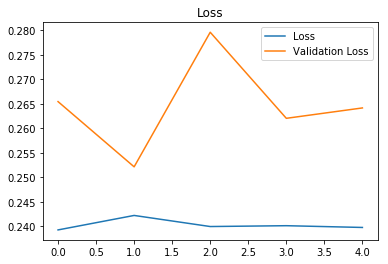

In [34]:
ea = EarlyStopping(patience=5)
cb = [ea]
history = model.fit(x_train, x_train, batch_size=512, epochs=30, validation_split=0.3, callbacks=cb)

plt.figure()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

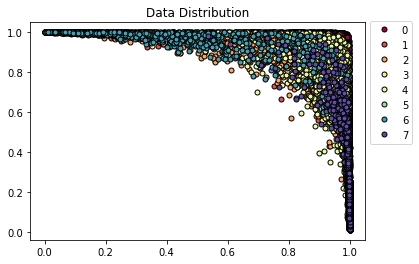

{'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7}


In [35]:
enc = Model(input_img, encoded)
encodings = enc.predict(x_train)

labels = y_train
unique_labels = [i for i in range(8)]
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 8)]
core_samples_mask = np.zeros_like(labels, dtype=bool)
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = encodings[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = encodings[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label=str(k))
    plt.legend(bbox_to_anchor=(1, 1.03))
plt.title('Data Distribution')
plt.show()
print({'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
               'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7})

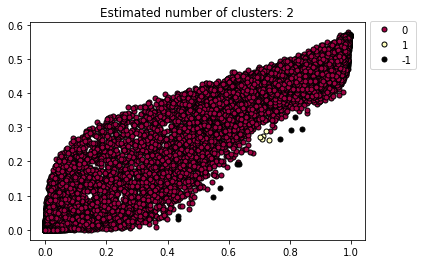

In [25]:
clustering = DBSCAN(eps=0.0225).fit(encodings)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = encodings[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = encodings[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label=str(k))
    plt.legend(bbox_to_anchor=(1, 1.03))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
dic = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': []}
for i, j in zip(y_train, labels):
    dic[str(i)].append(j)
for key in dic:
    dic[key] = set(dic[key])
print(dic)
label_dic = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
               'Loc': 4, 'Near-full': 5, 'Random': 6, 'Scratch': 7}
print(label_dic)